In [10]:
from d2l import torch as d2l
import torch.nn as nn
import torch
from torchsummary import summary
import time
import numpy as np
import torchvision
from torchvision.transforms import v2
from torch.utils.data import ConcatDataset
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

In [5]:
class AlexNet(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(96, kernel_size=11, stride=4, padding=1),
            nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LazyConv2d(256, kernel_size=5, padding=2), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LazyConv2d(384, kernel_size=3, padding=1), nn.ReLU(),
            nn.LazyConv2d(384, kernel_size=3, padding=1), nn.ReLU(),
            nn.LazyConv2d(256, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2), nn.Flatten(),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(p=0.5),
            nn.LazyLinear(4096), nn.ReLU(),nn.Dropout(p=0.5),
            nn.LazyLinear(num_classes))
        self.net.apply(d2l.init_cnn)

### 1. Following up on the discussion above, analyze the computational properties of AlexNet.

1. Compute the memory footprint for convolutions and fully connected layers, respectively. Which one dominates?
1. Calculate the computational cost for the convolutions and the fully connected layers.
1. How does the memory (read and write bandwidth, latency, size) affect computation? Is there any difference in its effects for training and inference?

(1) The fully connected layers have much more parameters.

In [5]:
model = AlexNet()
X = torch.randn((1, 3, 224, 224), requires_grad=True)

_ = model(X)
summary(model, (3, 224, 224))

c:\Users\Administrator.DESKTOP-II8P465\anaconda3\envs\d2l\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 10]                  --
|    └─Conv2d: 2-1                       [-1, 96, 54, 54]          34,944
|    └─ReLU: 2-2                         [-1, 96, 54, 54]          --
|    └─MaxPool2d: 2-3                    [-1, 96, 26, 26]          --
|    └─Conv2d: 2-4                       [-1, 256, 26, 26]         614,656
|    └─ReLU: 2-5                         [-1, 256, 26, 26]         --
|    └─MaxPool2d: 2-6                    [-1, 256, 12, 12]         --
|    └─Conv2d: 2-7                       [-1, 384, 12, 12]         885,120
|    └─ReLU: 2-8                         [-1, 384, 12, 12]         --
|    └─Conv2d: 2-9                       [-1, 384, 12, 12]         1,327,488
|    └─ReLU: 2-10                        [-1, 384, 12, 12]         --
|    └─Conv2d: 2-11                      [-1, 256, 12, 12]         884,992
|    └─ReLU: 2-12                        [-1, 256, 12, 12] 

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 10]                  --
|    └─Conv2d: 2-1                       [-1, 96, 54, 54]          34,944
|    └─ReLU: 2-2                         [-1, 96, 54, 54]          --
|    └─MaxPool2d: 2-3                    [-1, 96, 26, 26]          --
|    └─Conv2d: 2-4                       [-1, 256, 26, 26]         614,656
|    └─ReLU: 2-5                         [-1, 256, 26, 26]         --
|    └─MaxPool2d: 2-6                    [-1, 256, 12, 12]         --
|    └─Conv2d: 2-7                       [-1, 384, 12, 12]         885,120
|    └─ReLU: 2-8                         [-1, 384, 12, 12]         --
|    └─Conv2d: 2-9                       [-1, 384, 12, 12]         1,327,488
|    └─ReLU: 2-10                        [-1, 384, 12, 12]         --
|    └─Conv2d: 2-11                      [-1, 256, 12, 12]         884,992
|    └─ReLU: 2-12                        [-1, 256, 12, 12] 

(2) The convolution layers have more calculations and take more time.

Fomula of the computational cost for convolutions is $\sum^{layers} c_i \times c_o \times k_h \times k_w \times W \times H$

$$3*96*11*11*54*54+96*256*5*5*26*26+256*384*3*3*12*12+384*384*3*3*12*12+384*256*3*3*12*12 = 962858112$$

Fomula of the computational cost for fully connected layers is $x_i * x_o + x_o$

$$80*80*4096+4096+4096*4096+4096+4096*10+10 = 43040778$$

In [10]:
with torch.autograd.profiler.profile(use_cuda=True) as prof:
    model(X.to('cuda'))
print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))

---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                     aten::conv2d         1.27%      30.000us        28.95%     683.000us     136.600us      24.000us         0.03%      57.587ms      11.517ms             5  
                aten::convolution         3.22%      76.000us        27.68%     653.000us     130.600us      24.000us         0.03%      57.563ms      11.513ms             5  
               aten::_convolution         5.81%     137.000us        24.46%     577.000us     115.400us      56.000us  

(3)

- Read and Write Bandwidth: High read and write bandwidth enables faster data movement between memory and processing units. It allows for efficient data retrieval and storage during computations. Both training and inference benefit from high bandwidth. But bandwidth is often more crucial to training due to the frequent updates of weights and gradients during backpropagation.

- Latency: Latency is the time taken to access data from memory. Lower latency results in quicker data access and faster computations. Latency affects both training and inference. 

- Memory Size: Memory size determines how much data can be stored. Larger memory allows for more data to be cached, so large batchsize can be used. It is more crucial to training as training often takes much more memory.

### 2. You are a chip designer and need to trade off computation and memory bandwidth. For example, a faster chip requires more power and possibly a larger chip area. More memory bandwidth requires more pins and control logic, thus also more area. How do you optimize?

Firstly we should determine the usage scenarios and understand the specific requirements of the target application. We can explore different architectural options to determine the optimal balance between computation units (cores, SIMD units, accelerators) and memory subsystems (cache hierarchy, memory banks). Design memory hierarchies that provide efficient data access and minimize memory bottlenecks. Balance the chip area between computation and memory components based on performance requirements, available space, and cost constraints. Consider integrating memory close to computational units to reduce memory latency and improve memory bandwidth.

### 3. Why do engineers no longer report performance benchmarks on AlexNet?

Over the years, more advanced architectures like VGG, ResNet, Inception, and Transformer-based models (BERT, GPT, etc.) have been developed and have become more popular for benchmarking and research. These architectures often achieve better accuracy and efficiency than AlexNet.

### 4. Try increasing the number of epochs when training AlexNet. Compared with LeNet, how do the results differ? Why?

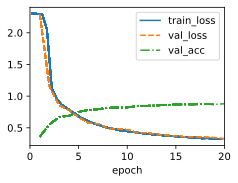

In [3]:
model = AlexNet(lr=0.01)
data = d2l.FashionMNIST(batch_size=128, resize=(224, 224))
trainer = d2l.Trainer(max_epochs=20, num_gpus=1)
trainer.fit(model, data)

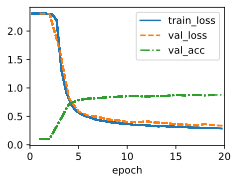

In [4]:
model = d2l.LeNet()
data = d2l.FashionMNIST(batch_size=128, resize=(224, 224))
trainer = d2l.Trainer(max_epochs=20, num_gpus=1)
trainer.fit(model, data)

I haven't found much difference. The validation loss is a little higher than training loss in the process of training LeNet, which may indicates that lenet is overfitting.

### 5. AlexNet may be too complex for the Fashion-MNIST dataset, in particular due to the low resolution of the initial images.

1. Try simplifying the model to make the training faster, while ensuring that the accuracy does not drop significantly.
2. Design a better model that works directly on $28\times 28$ images.

(1) The origin model:

time  235.4424648284912
accuracy  0.8332674


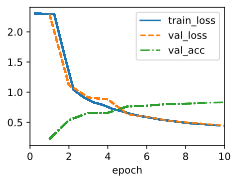

In [16]:
model = AlexNet(lr=0.01)
data = d2l.FashionMNIST(batch_size=128, resize=(224, 224))
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
time1 = time.time()
trainer.fit(model, data)
time2 = time.time()
print("time ", time2-time1)

accuracys = []
for i, data in enumerate(data.get_dataloader(train=False)):
    X, y = data
    y_hat = model(X.to('cuda')).to('cpu')
    accuracys.append(model.accuracy(y_hat, y))
print('accuracy ', np.array(accuracys).mean())

The simplified model:

time  141.33523631095886
accuracy  0.81141216


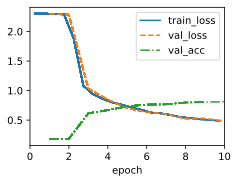

In [15]:
class SimplifiedAlexNet(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(48, kernel_size=11, stride=4, padding=1),
            nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LazyConv2d(128, kernel_size=5, padding=2), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LazyConv2d(192, kernel_size=3, padding=1), nn.ReLU(),
            nn.LazyConv2d(192, kernel_size=3, padding=1), nn.ReLU(),
            nn.LazyConv2d(128, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2), nn.Flatten(),
            nn.LazyLinear(2048), nn.ReLU(), nn.Dropout(p=0.5),
            nn.LazyLinear(2048), nn.ReLU(),nn.Dropout(p=0.5),
            nn.LazyLinear(num_classes))
        self.net.apply(d2l.init_cnn)

model = SimplifiedAlexNet(lr=0.01)
data = d2l.FashionMNIST(batch_size=128, resize=(224, 224))
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
time1 = time.time()
trainer.fit(model, data)
time2 = time.time()
print("time ", time2-time1)

accuracys = []
for i, data in enumerate(data.get_dataloader(train=False)):
    X, y = data
    y_hat = model(X.to('cuda')).to('cpu')
    accuracys.append(model.accuracy(y_hat, y))
print('accuracy ', np.array(accuracys).mean())

(2) design a better model

time  333.77113819122314
accuracy  0.9023932


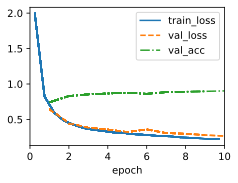

In [3]:
class MyNet(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(256, kernel_size=3, padding=1),nn.ReLU(),
            nn.LazyConv2d(256, kernel_size=3, padding=1),nn.ReLU(),
            nn.LazyConv2d(256, kernel_size=3, padding=1),nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LazyConv2d(512, kernel_size=3, padding=1),nn.ReLU(),
            nn.LazyConv2d(512, kernel_size=3, padding=1),nn.ReLU(),
            nn.LazyConv2d(256, kernel_size=3, padding=1),nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2), nn.Flatten(),
            nn.LazyLinear(1024), nn.ReLU(),
            nn.LazyLinear(num_classes))
        self.net.apply(d2l.init_cnn)

model = MyNet(lr=0.05)
data = d2l.FashionMNIST(batch_size=128, resize=(28, 28))
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
time1 = time.time()
trainer.fit(model, data)
time2 = time.time()
print("time ", time2-time1)

accuracys = []
for i, data in enumerate(data.get_dataloader(train=False)):
    X, y = data
    y_hat = model(X.to('cuda')).to('cpu')
    accuracys.append(model.accuracy(y_hat, y))
print('accuracy ', np.array(accuracys).mean())

### 6. Modify the batch size, and observe the changes in throughput (images/s), accuracy, and GPU memory.

How to get the throughput?

In [ ]:
batch_sizes = [64, 128, 256]
acc = []
throughputs = []

for batch_size in batch_sizes:
    model = AlexNet(lr=0.01)
    data = d2l.FashionMNIST(batch_size=batch_size, resize=(224, 224))
    trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
    time1 = time.time()
    trainer.fit(model, data)
    time2 = time.time()
    throughput = (len(data.train) + len(data.val)) * 10 / (time2 - time1)
    throughputs.append(throughput)

    accuracys = []
    for i, data in enumerate(data.get_dataloader(train=False)):
        X, y = data
        y_hat = model(X.to('cuda')).to('cpu')
        accuracys.append(model.accuracy(y_hat, y))
    acc.append(np.array(accuracys).mean())

Larger batchsize has higher throughput and accuracy, uses more GPU memory.

### 7. Apply dropout and ReLU to LeNet-5. Does it improve? Can you improve things further by preprocessing to take advantage of the invariances inherent in the images?

Apply dropout and ReLU to LeNet-5:

In [4]:
class LeNet(d2l.Classifier):  #@save
    """The LeNet-5 model."""
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120), 
            nn.ReLU(), nn.Dropout(0.5),
            nn.LazyLinear(84), 
            nn.ReLU(), nn.Dropout(0.5),
            nn.LazyLinear(num_classes))

accuracy  0.8724288


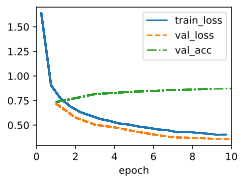

In [2]:
model = LeNet(lr=0.1)
data = d2l.FashionMNIST(batch_size=128, resize=(28, 28))
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
trainer.fit(model, data)

accuracys = []
for i, data in enumerate(data.get_dataloader(train=False)):
    X, y = data
    y_hat = model(X.to('cuda')).to('cpu')
    accuracys.append(model.accuracy(y_hat, y))
print('accuracy ', np.array(accuracys).mean())

(2) We can augment data to improve the performance.

accuracy  0.8929984


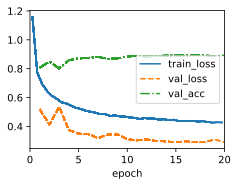

In [8]:
class AugmentFashionMNIST(d2l.FashionMNIST):
    def __init__(self, batch_size=64, resize=(28, 28)):
        super().__init__()
        self.save_hyperparameters()


        train_trans = v2.Compose([
            v2.RandomResizedCrop(size=resize, scale=(0.5, 1.0)),
            v2.RandomHorizontalFlip(p=0.5),
            v2.ToTensor(),
            v2.ToDtype(torch.float32),
            v2.Normalize(mean=[0.485], std=[0.229]),
        ])

        trans = v2.Compose([
            v2.Resize(size=resize),
            v2.ToTensor(),
            v2.ToDtype(torch.float32),
            v2.Normalize(mean=[0.485], std=[0.229]),
        ])
        
        fashionMnist = torchvision.datasets.FashionMNIST(
            root=self.root, train=True, transform=trans, download=True)
        fashionMnistAug = torchvision.datasets.FashionMNIST(
            root=self.root, train=True, transform=train_trans, download=True)
        self.train = ConcatDataset([fashionMnistAug, fashionMnist])
        self.val = torchvision.datasets.FashionMNIST(
            root=self.root, train=False, transform=trans, download=True)

model = LeNet(lr=0.1)
data = AugmentFashionMNIST(batch_size=128, resize=(28, 28))
trainer = d2l.Trainer(max_epochs=20, num_gpus=1)
trainer.fit(model, data)

accuracys = []
for i, data in enumerate(data.get_dataloader(train=False)):
    X, y = data
    y_hat = model(X.to('cuda')).to('cpu')
    accuracys.append(model.accuracy(y_hat, y))
print('accuracy ', np.array(accuracys).mean())

### 8. Can you make AlexNet overfit? Which feature do you need to remove or change to break training?

I tried to use less data, remove the dropout and regularization method, train more epochs.

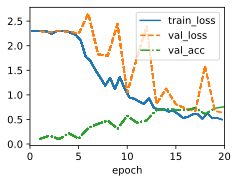

In [17]:
class OverfitAlexNet(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(96, kernel_size=11, stride=4, padding=1),
            nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LazyConv2d(256, kernel_size=5, padding=2), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LazyConv2d(384, kernel_size=3, padding=1), nn.ReLU(),
            nn.LazyConv2d(384, kernel_size=3, padding=1), nn.ReLU(),
            nn.LazyConv2d(256, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2), nn.Flatten(),
            nn.LazyLinear(4096), nn.ReLU(), 
            nn.LazyLinear(4096), nn.ReLU(),
            nn.LazyLinear(num_classes))
        self.net.apply(d2l.init_cnn)

class LessFashionMNIST(d2l.FashionMNIST):
    def __init__(self, batch_size=64, resize=(28, 28)):
        super().__init__()
        self.save_hyperparameters()

        trans = v2.Compose([
            v2.Resize(size=resize),
            v2.ToTensor(),
            v2.ToDtype(torch.float32),
        ])
        
        dataset = torchvision.datasets.FashionMNIST(
            root=self.root, train=True, transform=trans, download=True)

        indices = np.arange(len(dataset))
        train_indices, test_indices = train_test_split(indices, test_size=2000, train_size=1000, stratify=dataset.targets)

        self.train = Subset(dataset, train_indices)
        self.val = Subset(dataset, test_indices)

model = OverfitAlexNet(lr=0.1)
data = LessFashionMNIST(batch_size=32, resize=(224, 224))
trainer = d2l.Trainer(max_epochs=20, num_gpus=1)
trainer.fit(model, data)